# Dinâmica de populações neuronais

Nesta atividade, exploraremos populações interagentes de neurônios, utilizando modelos para redes pequenas baseados em taxas de disparo. Essencialmente, iremos reproduzir alguns dos resultados discutidos no artigo de Paul Miller[1].

O modelo estudado é composto por duas populações neuronais. Cada população envia projeções para a outra e para si mesma, sendo os pesos de cada uma destas quatro conexões representados por uma matriz $W$. A dinâmica de cada população é idêntica, segundo o modelo para taxas de disparo visto em aula:

$$
\newcommand{\ud}{\mathrm{d}}
    \tau\frac{\ud \mathbf{v}}{\ud t} = -\mathbf{v} + \mathbf{f}(W{\mathbf{v}+\mathbf{I}}),
$$

sendo $\mathbf{v}=(v_1,v_2)$ o vetor com as taxas de disparo de cada população, $W$ a matriz com pesos para cada conexão, $\mathbf{f}$ a função de ativação (que transforma entradas em taxa de disparos) e $\mathbf{I}$ um vetor representando um estímulo externo aplicado à rede. Para todos os casos, a função de ativação $\mathbf{f}$ é tomada como retificação linear, com um limiar de ativação variável (variável `limiar` no código abaixo, contendo dois elementos, um para cada população) e taxa de disparos máxima de $100 \mathrm{Hz}$. Determinaremos o comportamento de três redes distintas, obtidas mediante a variação dos pesos $W$ e dos limiares de ativação na função $\mathbf{f}$. 

Para cada um dos três conjuntos de parâmetros no código abaixo, determine

- Grafo de conectividade (faça um desenho)
- Séries temporais para as taxas de disparo $r_1$ (população 1), $r_2$ (população 2) e $I$ (corrente injetada)
- Espaço de estados em duas circunstâncias:
    - sem injeção de corrente
    - durante o segundo pulso de corrente


Com base nestas informações, discuta o comportamento de cada uma das três redes, e que tipo de função computacional ela pode desempenhar.

[1]: Miller, Paul. "Dynamical systems, attractors, and neural circuits." F1000Research 5 (2016). https://f1000research.com/articles/5-992</a>

In [1]:
import numpy as np
import matplotlib.pyplot as p

In [2]:
#############################
# Conjunto de parâmetros 1  #
#############################
# W = np.array([[0.8, -0.4], [0.8, -0.2]]) 
# pulso_corrente_1 = np.array([10, 0])
# pulso_corrente_2 = np.array([30, 0])
# limiar = np.array([-15, -15])
# taxas_iniciais = np.array([10, 50])

#############################
# Conjunto de parâmetros 2  #
#############################
# W = np.array([[1.1, -0.15], [-0.15, 1.1]]) 
# pulso_corrente_1 = np.array([0, 25])
# pulso_corrente_2 = np.array([25, 0])
# limiar = np.array([5, 5])
# taxas_iniciais = np.array([50, 55])


#############################
# Conjunto de parâmetros 3  #
#############################
W = np.array([[0.7, -0.3], [-0.3, 0.7]])
pulso_corrente_1 = np.array([1, 0])
pulso_corrente_2 = np.array([2, 0])
limiar = np.array([-20, -20])
taxas_iniciais = np.array([30, 75])

rmax = 100  # taxa de disparo máxima


In [3]:
def dinamica(r, W, limiar, I):
    tau = 0.01
    return (np.dot(W-np.eye(2), r) + I - limiar)/tau

def pulso(t, ti, tf):
    return np.heaviside(t-ti, 0) - np.heaviside(t-tf,0.5)

def integra_rede(W, limiar, r0, I, rmax, dt=0.0001, passos=30000):
    
    r = np.zeros((passos, 2))   
    r[0, :] = r0                # condições iniciais

    for i in range(passos - 1):
        rr = r[i, :] + dt * dinamica(r[i, :], W, limiar, I[i]) 
        r[i+1, :] = np.maximum(rr, 0)  # taxa mínima: 0                     
        r[i+1, :] = np.minimum(r[i+1, :], rmax)  # taxa máxima: rmax 
            
    return r

In [4]:
dt = 0.0001
passos = 30000
I = [pulso_corrente_1 * pulso(t, 1/dt, 1.2/dt) +
     pulso_corrente_2*pulso(t, 2/dt, 2.2/dt) 
     for t in range(int(3/dt))]
r = integra_rede(W, limiar, taxas_iniciais, I, rmax, dt=dt)
t = np.arange(0, passos*dt, dt)

Text(0, 0.5, 'Injeção de corrente')

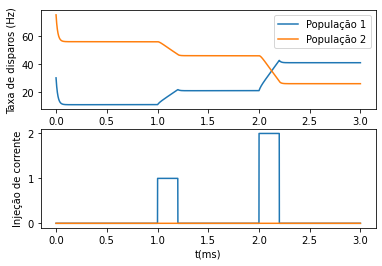

In [5]:
# séries temporais da taxa de disparos de cada população
fig, axs = p.subplots(2, 1)
axs[0].plot(t, r[:, 0], label='População 1')
axs[0].plot(t, r[:, 1], label='População 2')
axs[0].legend()
axs[0].set_ylabel('Taxa de disparos (Hz)')
axs[1].plot(t, I)
axs[1].set_xlabel('t(ms)')
axs[1].set_ylabel('Injeção de corrente')

In [6]:
def isoclinas(W, limiar, I, rmax, ax):
    
    # Isóclina nula para r_2 [pontos onde dr_2/dt = 0]
    x = np.arange(100)  # valores de r1 equiespaçados 
    y = (W[1,0]*x - limiar[1] + I[1])/(1-W[1,1]) # valores de r_2 para os quais dr_2/dt=0.

    permitidos = (y>0) & (y<rmax)  # só queremos soluções neste intervalo

    ax.plot(x[permitidos], y[permitidos],'r')
    ax.set_aspect('equal', 'box')
    ax.set_xlabel('$r_1$ (Hz)')
    ax.set_ylabel('$r_2$ (Hz)')

    # Soluções saturadas existem onde r_2 = rmax, se para estes dr_2/dt > 0
    drdt_maxy_vals = W[1,0]*x +(W[1,1]-1)*rmax - limiar[1] + I[1]
    max_vals = np.flatnonzero(drdt_maxy_vals > 0)
    ax.plot(x[max_vals], rmax * np.ones_like(max_vals), 'r')

    # Soluções possíveis abaixo do limiar, onde r_2 = 0, se para estes dr_2/dt < 0 
    drdt_zeroy_vals = W[1,0]*x - limiar[1] + I[1]
    zero_vals = np.flatnonzero(drdt_zeroy_vals < 0)
    ax.plot(x[zero_vals], np.zeros_like(zero_vals), 'r')


    # Isóclina nula para r_1 [pontos onde dr_1/dt = 0]
    y = np.arange(100)                  
    x = (W[0,1]*y - limiar[0] + I[0])/(1-W[0,0])

    permitidos = (x>0) & (x<rmax)     
    ax.plot(x[permitidos], y[permitidos], 'k')
   
    # saturadas
    drdt_maxx_vals = W[0,1]*y +(W[0,0]-1)*rmax - limiar[0] + I[0]
    max_vals = np.flatnonzero(drdt_maxx_vals > 0)
    ax.plot(rmax * np.ones_like(max_vals), y[max_vals],'k')

    # Soluções possíveis abaixo do limiar, onde r_1 = 0, se para estes dr_1/dt < 0 
    drdt_zerox_vals = W[0,1]*y - limiar[0] + I[0]
    zero_vals = np.flatnonzero(drdt_zerox_vals < 0)
    ax.plot(np.zeros_like(zero_vals), y[zero_vals], 'k')
        

    
def campo_vetorial(W, limiar, I, rmax, ax):
    xvals = np.arange(5, 96,10)
    yvals = np.arange(5, 96, 10)
    [xgrid, ygrid] = np.meshgrid(xvals,yvals)    
    flatx = xgrid.ravel()
    flaty = ygrid.ravel()
    drdtvals = dinamica([flatx, flaty], W, limiar.reshape(2,1), I.reshape(2,1)) 

    ax.quiver(xgrid, ygrid, drdtvals[0,:], drdtvals[1,:])

    ax.axis([-5, rmax+5, -5,rmax+5])
    

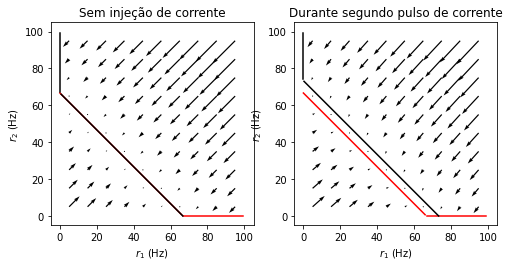

In [7]:
# espaço de estados para corrente nula
fig, eixos = p.subplots(1,2, figsize=(8,4))
sem_I = np.array([0,0])
eixos[0].set_title('Sem injeção de corrente')
ax = isoclinas(W, limiar, sem_I, rmax, eixos[0])
campo_vetorial(W, limiar, sem_I, rmax, eixos[0])

# espaço de estados para segundo pulso de corrente
eixos[1].set_title('Durante segundo pulso de corrente')
isoclinas(W, limiar, pulso_corrente_2, rmax, eixos[1])
campo_vetorial(W, limiar, pulso_corrente_2, rmax, eixos[1])